In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd 'drive/MyDrive/Colab Notebooks/BMI-Decoding'

/content/drive/MyDrive/Colab Notebooks/BMI-Decoding


In [4]:
# import packages
import h5py
import numpy as np
from functions.preprocess import input_shaping, split_index
from functions.decoders import lstm_decoder
from functions.metrics import compute_rmse, compute_pearson
import matplotlib.pyplot as plt
import seaborn as sns
import time as timer
from tensorflow import random

In [5]:
seed = 2020 # random seed for reproducibility

print ("Starting simulation")
run_start = timer.time()

feature_list = ['sua_rate','mua_rate']
feature = feature_list[1] # select which spike feature: SUA=0, MUA=1

# specify filename to be processed (choose from the list available at https://zenodo.org/record/583331)
file_name = 'indy_20160915_01'          # file name
kinematic_folder = 'kinematic_data/'    # kinematic data folder
feature_folder = 'spike_data/features/' # spike features folder
result_folder = 'results/'              # results folder

Starting simulation


In [6]:
wdw_time = 0.256 # window size in second
lag = -32 # lag between kinematic and feature data (minus indicate feature lagging behaind kinematic)
delta_time = 0.004 # sampling interval in second
wdw_samp = int(round(wdw_time/delta_time))
ol_samp = wdw_samp-1

## Importing data to be processed

In [7]:
# open spike features from hdf5 file
feature_file = feature_folder+file_name+'_spike_features_'+str(int(wdw_time*1e3))+'ms.h5'
print ("Loading input features from file: "+feature_file)
with h5py.File(feature_file,'r') as f:
    input_feature = f[feature].value

Loading input features from file: spike_data/features/indy_20160915_01_spike_features_256ms.h5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """


In [8]:
# open kinematic data from hdf5 file
kinematic_file = kinematic_folder+file_name+'_kinematic_data.h5'
print ("Loading kinematic data from file: "+kinematic_file)
#fields: ['cursor_acc', 'cursor_pos', 'cursor_time', 'cursor_vel', 'target_pos']
with h5py.File(kinematic_file,'r') as f:
    cursor_vel = f['cursor_vel'].value # in mm/s

Loading kinematic data from file: kinematic_data/indy_20160915_01_kinematic_data.h5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


## Preprocessing the data to fit a model

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(input_feature)
y_mm = mm.fit_transform(cursor_vel)

In [10]:
print(X_ss.shape, y_mm.shape)

(95262, 88) (95262, 2)


In [11]:
#first 80,000 for training

X_train = X_ss[:80000, :]
X_test = X_ss[80000:, :]

y_train = y_mm[:80000, :]
y_test = y_mm[80000:, :] 

In [12]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (80000, 88) (80000, 2)
Testing Shape (15262, 88) (15262, 2)


## Adjusting the data for pytorch model

In [13]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

In [14]:
#converting nparrays to tensors for pytorch

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))


In [15]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([80000, 1, 88]) torch.Size([80000, 2])
Testing Shape torch.Size([15262, 1, 88]) torch.Size([15262, 2])


## Importing spytorch functions

In [16]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 88*1
nb_hidden  = 100
nb_outputs = 2

time_step = 1e-3
nb_steps  = 100

batch_size = 256

dtype = torch.float
# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [17]:
tau_mem = 10e-3
tau_syn = 5e-3

beta    = float(np.exp(-time_step/tau_mem))
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with



print("init done")

init done


In [18]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T
 

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, sample_size=nb_steps,overlap_units=1,shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(0,len(X)-sample_size,overlap_units)

#     # compute discrete firing times
#     tau_eff = 20e-3/time_step
#     firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
#     unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        
#         for batch_sample_i in range(batch_size):
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        
        X_batch = np.zeros((batch_size,sample_size,X.shape[-1]))
        y_batch = np.zeros((batch_size,y.shape[-1]))
        for bc,idx in enumerate(batch_index):
            X_batch[bc,:,:] = X[idx:idx+sample_size,:,:].reshape((1,sample_size,X.shape[-1]))
            y_batch[bc, :] = y[idx+sample_size,:]
            
#         i = torch.LongTensor(coo).to(device)
#         v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.FloatTensor(X_batch).to(device)
        y_batch = torch.tensor(y_batch,device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [19]:

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [20]:
class Spiking_Linear_layer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()

        self.alpha   = float(np.exp(-time_step/tau_syn))
        self.beta    = float(np.exp(-time_step/tau_mem))

        weight_scale = 7*(1.0-self.beta) # this should give us some spikes to begin with

        self.size_in = size_in
        self.size_out = size_out

        self.w1 = torch.empty((size_in, size_out),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(self.w1, mean=0.0, std=weight_scale/np.sqrt(size_in))

    def forward(self, inputs):
        h1 = torch.einsum("abc,cd->abd", (inputs, self.w1))
        syn = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)
        mem = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)

        mem_rec = []
        spk_rec = []
        

        # Compute hidden layer activity
        for t in range(nb_steps):
            # if t%5==0:
            #     print(t/nb_steps, ' ', end='')
            mthr = mem-1.0
            out = spike_fn(mthr)
            rst = out.detach() # We do not want to backprop through the reset

            new_syn = self.alpha*syn +h1[:,t,:]
    #         new_mem = (self.beta*mem +syn)*(1.0-rst)
            new_mem = self.beta*(mem - rst) + rst + (1 - self.beta)*syn

            mem_rec.append(mem)
            spk_rec.append(out)
            
            mem = new_mem
            syn = new_syn
        # print('')

        mem_rec = torch.stack(mem_rec,dim=1)
        spk_rec = torch.stack(spk_rec,dim=1)

        return mem_rec, spk_rec

In [21]:
class Spiking_Readout(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()

        self.alpha   = float(np.exp(-time_step/tau_syn))
        self.beta    = float(np.exp(-time_step/tau_mem))

        self.size_in = size_in
        self.size_out = size_out

        weight_scale = 7*(1.0-self.beta) # this should give us some spikes to begin with

        self.w2 = torch.empty((size_in, size_out), device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(self.w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

    def forward(self, inputs):
                # Readout layer - make into different module, and then make a new module that's a NN module
        h2= torch.einsum("abc,cd->abd", (inputs, self.w2))
        flt = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)
        out = torch.zeros((batch_size,self.size_out), device=device, dtype=dtype)
        out_rec = []
        for t in range(nb_steps):
            new_flt = self.alpha*flt +h2[:,t]
            new_out = self.beta*out +flt

            flt = new_flt
            out = new_out

            out_rec.append(out)

        out_rec = torch.stack(out_rec,dim=1)
        out_rec = out_rec.reshape(batch_size,-1)

        return out_rec

In [22]:
class Spiking_Network(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Spiking_Network, self).__init__()
        self.spk1 = Spiking_Linear_layer(D_in, H)
        self.spk2 = Spiking_Linear_layer(H, H)
        self.spk3 = Spiking_Linear_layer(H, H)
        self.spk4 = Spiking_Linear_layer(H, H)
        self.rd_out = Spiking_Readout(H, D_out)
        self.linear1 = nn.Linear(D_out*H, D_out).to(device)

    def forward(self, inputs):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        mem_rec,spk_rec = self.spk1(inputs)
        mem_rec,spk_rec = self.spk2(spk_rec)
        mem_rec,spk_rec = self.spk3(spk_rec)
        mem_rec,spk_rec = self.spk4(spk_rec)

        out_rec = self.rd_out(spk_rec)
        out_rec = self.linear1(out_rec)

        other_recs = [mem_rec, spk_rec]
        return out_rec, other_recs

In [23]:
def train(x_data, y_data, x_val, y_val, lr=2e-3, nb_epochs=10):

    model = Spiking_Network(nb_inputs, nb_hidden, nb_outputs)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999))

    linear_fn = nn.LogSoftmax(dim=1)
    # linear_fn = nn.Linear(2,2)
    loss_fn = nn.MSELoss()
    
    loss_hist = []
    loss_hist_val = []
    for e in range(nb_epochs):
        local_loss = []
        local_val_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output,_ = model(x_local)
            # velocity_out,_=torch.max(output,1)
            # velocity_out = linear_fn(m)
            loss_train = loss_fn(output.float(), y_local.float())
            


            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            local_loss.append(loss_train.item())

        for x_local, y_local in sparse_data_generator(x_val, y_val, batch_size, nb_steps, nb_inputs):
            val_out,_ = model(x_local)
            loss_test = loss_fn(val_out.float(), y_local.float())
            
            local_val_loss.append(loss_test.item())
        
        mean_loss = np.mean(local_loss)
        mean_val_loss = np.mean(local_val_loss)

        print("Epoch %i: loss=%.5f  validation loss=%.5f"%(e+1,mean_loss,mean_val_loss))

        loss_hist.append(mean_loss)
        loss_hist_val.append(mean_val_loss)
        
    return model, loss_hist, loss_hist_val

In [24]:
import gc
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing


In [25]:
model, loss_hist, val_loss = train(X_train_tensors_final, y_train_tensors, X_test_tensors_final, y_test_tensors, lr=2e-4, nb_epochs=20)

Epoch 1: loss=0.95461  validation loss=0.28252
Epoch 2: loss=0.19743  validation loss=0.13468
Epoch 3: loss=0.11159  validation loss=0.08835
Epoch 4: loss=0.07831  validation loss=0.06482
Epoch 5: loss=0.06014  validation loss=0.05118
Epoch 6: loss=0.04800  validation loss=0.04142
Epoch 7: loss=0.03915  validation loss=0.03397
Epoch 8: loss=0.03237  validation loss=0.02791
Epoch 9: loss=0.02707  validation loss=0.02409
Epoch 10: loss=0.02287  validation loss=0.02164
Epoch 11: loss=0.01940  validation loss=0.01700
Epoch 12: loss=0.01661  validation loss=0.01526
Epoch 13: loss=0.01445  validation loss=0.01330
Epoch 14: loss=0.01272  validation loss=0.01146
Epoch 15: loss=0.01141  validation loss=0.01111
Epoch 16: loss=0.01040  validation loss=0.01004
Epoch 17: loss=0.00967  validation loss=0.00944
Epoch 18: loss=0.00923  validation loss=0.00844
Epoch 19: loss=0.00871  validation loss=0.00880
Epoch 20: loss=0.00853  validation loss=0.00802


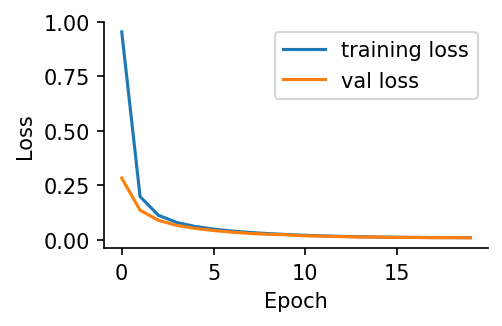

In [26]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.plot(val_loss)
plt.legend(['training loss', 'val loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [27]:
from scipy import stats


In [28]:
correlation_array = []

pred = []
y_val = []
for x_local, y_local in sparse_data_generator(X_test_tensors_final, y_test_tensors, batch_size, nb_steps, nb_inputs):
    val_out,_ = model(x_local)
    val_out = val_out.detach().cpu()
    print(stats.pearsonr(val_out.cpu(), y_local.cpu()))
    
    break


    correlation_array.append(np.corrcoef(val_out.cpu(), y_local.cpu())[0][1])

TypeError: ignored

In [ ]:
pred[0][1]

In [ ]:
np.corrcoef(pred[0][1],y_val[0])